In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

%matplotlib inline

In [2]:
file_path = Path("all_features.csv")
combined_df = pd.read_csv(file_path, infer_datetime_format = True, parse_dates = True, index_col = "date_time")
combined_df.sort_index(inplace=True)

In [3]:
#combined_df['target_price'] = combined_df['close'].shift(-1)
combined_df['target_return'] = combined_df['return'].shift(-1)
combined_df = combined_df.dropna()

In [4]:
combined_df

,close,vol,spy,return,Beta,WR,RSI,OBV,sentiment_vader,sentiment_rnn,us2y10y,vix,usdjpy,target_return
date_time,,,,,,,,,,,,,,
2021-01-28 09:30:00,5.190,1799686,376.500,-0.217183,-11.032931,-14.215073,14.839941,161951446.0,-1.0,-1.0,91.536,30.21,104.36,0.011561
2021-01-28 09:31:00,5.250,747568,376.780,0.011561,-10.872930,-100.000000,16.260163,162699014.0,1.0,1.0,91.536,30.17,104.33,-0.008571
2021-01-28 09:32:00,5.205,1004673,376.760,-0.008571,-10.873086,-96.314949,16.024324,161694341.0,0.0,0.0,91.536,30.24,104.31,0.006724
2021-01-28 09:33:00,5.240,1140496,377.040,0.006724,-10.740247,-99.025974,17.502677,162834837.0,0.0,0.0,91.706,29.96,104.30,0.034351
2021-01-28 09:34:00,5.420,29120247,376.830,0.034351,-10.907816,-96.644295,24.007937,191955084.0,0.0,0.0,91.875,29.75,104.31,0.013838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-31 15:54:00,3.965,50182,396.600,0.000000,0.660383,-75.000000,37.500000,422998364.0,0.0,0.0,157.321,18.89,110.75,0.000000
2021-03-31 15:55:00,3.965,67617,396.345,0.000000,0.617945,-50.000000,28.571429,423065981.0,0.0,0.0,157.142,19.01,110.73,0.000000
2021-03-31 15:56:00,3.965,328314,396.520,0.000000,0.591079,0.000000,40.000000,423394295.0,0.0,0.0,156.964,18.99,110.73,0.000000


In [5]:
X = combined_df[['return', 'Beta', 'WR', 'RSI', 'OBV', 'sentiment_vader', 'sentiment_rnn', 'us2y10y', 'vix', 'usdjpy']]

In [6]:
target = combined_df.iloc[:,13]
y = target.values.reshape(-1, 1)

In [7]:
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [8]:
# Importing the MinMaxScaler from sklearn
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the MinMaxScaler object with the features data X
scaler.fit(X_train)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit the MinMaxScaler object with the target data Y
scaler.fit(y_train)

# Scale the target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [9]:
# from sklearn.experimental import enable_halving_search_cv 
# from sklearn.model_selection import HalvingRandomSearchCV
# from sklearn.ensemble import GradientBoostingRegressor

# xgb = GradientBoostingRegressor(random_state=0, loss='ls')

# param_distributions = {"max_depth": [3, 5, 10],
#                         "learning_rate": [0.01, 0.1, 0.5, 0.75],
#                        #"n_estimators": [10, 100, 1000]
#                       }

# search = HalvingRandomSearchCV(xgb, param_distributions,
#                                resource = "n_estimators",
#                                max_resources=12,
#                                random_state=0).fit(X_train, y_train.ravel())
# search.best_params_

In [10]:
from sklearn.ensemble import GradientBoostingRegressor
model = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.75,
        max_depth=5, random_state=0, loss='ls')

In [11]:
# import xgboost as xgb
# model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.75,
#         max_depth=5, random_state=0)

In [12]:
# from sklearn.ensemble import AdaBoostRegressor
# ada = AdaBoostRegressor(random_state=0, n_estimators=1000, learning_rate = 0.75)

In [13]:
model.fit(X_train, y_train.ravel())

GradientBoostingRegressor(learning_rate=0.75, max_depth=5, n_estimators=1000,
                          random_state=0)

In [14]:
y_pred = model.predict(X_test)

In [15]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

0.0015914507351017875

In [16]:
model.score(X_test, y_test)

-9.645950001479802

In [17]:
predicted_value = scaler.inverse_transform(y_pred.reshape(-1,1))
real_value = scaler.inverse_transform(y_test)

In [18]:
output = pd.DataFrame({
    "Real": real_value.ravel(),
    "Predicted": predicted_value.ravel()
    }, index = combined_df.index[-len(real_value): ])
output.head()

,Real,Predicted
date_time,,
2021-03-12 14:41:00,-0.001199,-0.001012
2021-03-12 14:42:00,0.000000,0.000476
2021-03-12 14:43:00,0.001200,0.000089
2021-03-12 14:44:00,0.002398,-0.000546
2021-03-12 14:45:00,0.000000,-0.000040


<AxesSubplot:xlabel='date_time'>

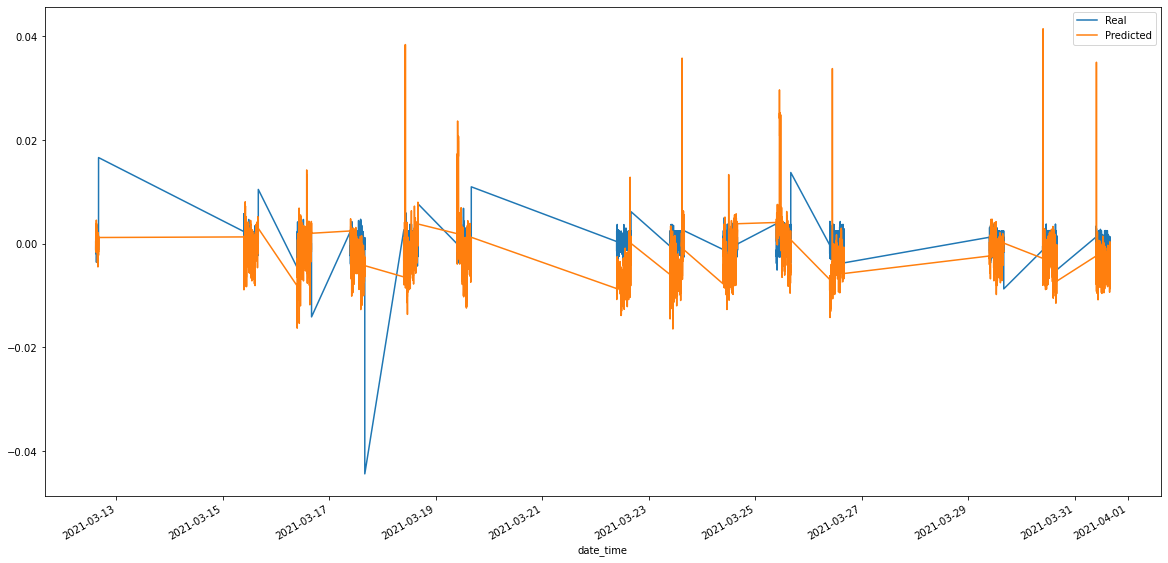

In [19]:
output.plot(figsize = (20,10))

In [20]:
model.feature_importances_ * 100

array([13.79641791, 14.47605541, 11.71877695,  8.63067893,  9.75768259,
        0.78332869,  1.38869421, 10.05334612, 24.34856064,  5.04645856])

In [21]:
output

,Real,Predicted
date_time,,
2021-03-12 14:41:00,-0.001199,-0.001012
2021-03-12 14:42:00,0.000000,0.000476
2021-03-12 14:43:00,0.001200,0.000089
2021-03-12 14:44:00,0.002398,-0.000546
2021-03-12 14:45:00,0.000000,-0.000040
...,...,...
2021-03-31 15:54:00,0.000000,-0.004669
2021-03-31 15:55:00,0.000000,-0.003200
2021-03-31 15:56:00,0.000000,-0.002716


In [22]:
output.describe()

,Real,Predicted
count,5148.000000,5148.000000
mean,-0.000009,-0.002300
std,0.001570,0.004462
min,-0.044393,-0.016458
25%,-0.001159,-0.005084
50%,0.000000,-0.002329
75%,0.001076,0.000259
max,0.016607,0.041450


In [23]:
output.sum()

Real         -0.044036
Predicted   -11.840638
dtype: float64

In [24]:
final_output = output.join(combined_df[['close']])
final_output.to_csv("predictions.csv")